In [831]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

import gurobipy as gp
from gurobipy import GRB, tuplelist

import pandapower.networks as pn

In [832]:
net = pn.case33bw()
# T = 3
T = 49
kVAbase = 1000 # kVA
MVAbase = kVAbase / 1000 # MVA
impbase = net.bus.vn_kv[0]**2/(MVAbase)

In [833]:
frombus,tobus = [],[]
for i in net.line.index:
    frombus.append(net.bus.loc[net.line.from_bus[i],'name'])
    tobus.append(net.bus.loc[net.line.to_bus[i],'name'])

[frombus,tobus]
net.line.from_bus = frombus
net.line.to_bus = tobus

In [834]:
net.bus.index = net.bus.name
net.line.index = [frombus,tobus]
net.line = net.line.loc[net.line.in_service == True]
net.line['rateA'] = 10000

In [835]:
r = net.line.length_km * net.line.r_ohm_per_km
x = net.line.length_km * net.line.x_ohm_per_km
net.line = net.line.assign(r=r)
net.line = net.line.assign(x=x)

# net.line.r.loc[(6,7)] += 1 # Adjust data mismatch
# net.line.x.loc[(6,7)] += 1

net.line = net.line.assign(r_pu=r/impbase)
net.line = net.line.assign(x_pu=x/impbase)
net.line = net.line[['from_bus','to_bus','r','x','r_pu','x_pu','rateA']]
net.bus = net.bus[['name','vn_kv']]

In [836]:
ldp,ldq = [],[]
for i in net.load.index:
    ldp.append(net.bus.loc[net.load.bus[i],'name'])
    ldq.append(net.bus.loc[net.load.bus[i],'name'])

# net.bus = net.bus.assign(Pd=0)
# net.bus = net.bus.assign(Qd=0)
net.bus['Pd'] = 0
net.bus['Qd'] = 0
for i in net.load.index:
    loca = net.bus.loc[net.load.bus[i],'name']
    # print(loca)
    net.bus.Pd[loca] = net.load.p_mw[i]*1000/kVAbase
    net.bus.Qd[loca] = net.load.q_mvar[i]*1000/kVAbase
# net.line

In [837]:
net.ext_grid['Pmin'] = net.ext_grid.min_p_mw*MVAbase
net.ext_grid['Pmax'] = net.ext_grid.max_p_mw*MVAbase
net.ext_grid['Qmin'] = net.ext_grid.min_q_mvar*MVAbase
net.ext_grid['Qmax'] = net.ext_grid.max_q_mvar*MVAbase

net.ext_grid.index = net.ext_grid.bus
net.ext_grid = net.ext_grid[['bus','Pmin','Pmax','Qmin','Qmax']]

dgloc = {'bus':[17], 'Pmin':[0], 'Pmax':[0.5], 'Qmin':[-0.3], 'Qmax':[0.3]}
dg = pd.DataFrame(dgloc)
net.ext_grid = pd.concat([net.ext_grid,dg])
net.ext_grid.index = net.ext_grid.bus
display( net.ext_grid)


,bus,Pmin,Pmax,Qmin,Qmax
bus,,,,,
0,0,0.0,10.0,-10.0,10.0
17,17,0.0,0.5,-0.3,0.3


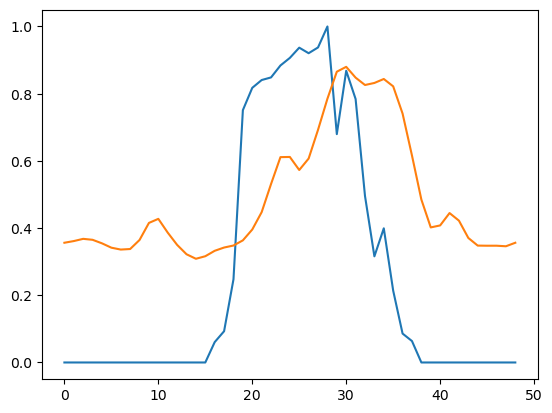

In [838]:
## PV and Load profile
pvloc = {'bus':[10, 16, 20], 'p_max':[0.3, 0.3, 0.3], 'q_min':[-0.3, -0.3, -0.3], 'q_max':[0.3, 0.3, 0.3]}
pvdata = pd.DataFrame(data=pvloc)
pvdata.index = pvdata.bus
pvgen = np.genfromtxt(fname='PV45-15mins.txt')
p_pv_max = pvgen / np.max(pvgen)

divisor = 2

p30 = p_pv_max[1:96:divisor]
p30 = np.append(p30,p30[0]) # Last hour same as the initial
plt.plot(p30)

loaddem = np.genfromtxt(fname='LD69-15mins.txt')
l30 = loaddem[1:96:divisor]
l30 = np.append(l30,l30[0])
plt.plot(l30)

In [839]:
## ESS data
# essloc = {'bus':[10, 16, 20],'Cap':[1,1,1],'Pmin':[0,0,0],'Pmax':[0.1,0.1,0.1],'Qmin':[-0.1,-0.1,-0.1],'Qmax':[0.1,0.1,0.1]}
essloc = {'bus':[6, 15, 30],'Cap':[1,1,1],'Pmin':[0,0,0],'Pmax':[0.1,0.1,0.1],'Qmin':[-0.1,-0.1,-0.1],'Qmax':[0.1,0.1,0.1]}
essdata = pd.DataFrame(essloc)
essdata.index = essdata.bus
essdata

,bus,Cap,Pmin,Pmax,Qmin,Qmax
bus,,,,,,
6,6,1,0,0.1,-0.1,0.1
15,15,1,0,0.1,-0.1,0.1
30,30,1,0,0.1,-0.1,0.1


In [840]:
# print(list_duplicates(set_line))
# line = line[~line.index.duplicated(keep='first')]
gen = net.ext_grid
line = net.line
bus = net.bus

In [841]:
slackbus = [0]
set_t = list(range(T)) # Please dont make in in range(x) format. It should be list or np.arrays

nGen = gen.shape[0]
set_gen = gen.index
gen_t = tuplelist([(i,t) for t in set_t for i in set_gen])

nBus = bus.shape[0]
set_bus = bus.index
bus_t = tuplelist([(i,t) for t in set_t for i in set_bus])

nLine = line.shape[0]
set_line = line.index
line_t = tuplelist([(i,j,t) for t in set_t for i,j in set_line])
# line_t_rev = tuplelist([(j,i,t) for t in set_t for i,j in set_line])

nPv = pvdata.shape[0]
set_pv = pvdata.index
pv_t = tuplelist([(i,t) for t in set_t for i in set_pv])

nEss = essdata.shape[0]
set_ess = essdata.index
ess_t = tuplelist([(i,t) for t in set_t for i in set_ess])

In [842]:
# Create index for aux vars
line_t_dir = tuplelist() # index for power flow direction
for t in set_t:
    for i,j in set_line:
        line_t_dir = line_t_dir + tuplelist([(i,j,t)]) + tuplelist([(j,i,t)])

In [843]:
# Function for obtaining reactance
# def resi(line_df,m,n,impbase=impbase):
#     if (m,n) not in line_df.index:
#         temp = m
#         m = n
#         n = temp
#     return (line_df.loc[(m,n),'r'] / impbase)

# def reac(line_df,m,n,impbase=impbase):
#     if (m,n) not in line_df.index:
#         temp = m
#         m = n
#         n = temp
#     return (line_df.loc[(m,n),'x'] / impbase)
def resi(line_df, m, n, impbase=impbase):
    # Using a tuple to check for membership is faster than using 'not in'
    idx = (m, n) if (m, n) in line_df.index else (n, m)
    # Accessing the 'r' column directly and then using .at for scalar value access
    return line_df.at[idx, 'r'] / impbase

def reac(line_df, m, n, impbase=impbase):
    # Using a tuple to check for membership is faster than using 'not in'
    idx = (m, n) if (m, n) in line_df.index else (n, m)
    # Accessing the 'r' column directly and then using .at for scalar value access
    return line_df.at[idx, 'x'] / impbase

# Suppose gij1 = kij1/x and gij2 = kij2/x
def gij1(line_df,m,n):
    r = resi(line_df,m,n)
    x = reac(line_df,m,n)
    return r/(r**2+x**2)

def gij2(line_df,m,n):
    r = resi(line_df,m,n)
    x = reac(line_df,m,n)
    return x/(r**2+x**2)

print(gij1(line,1,2))
print(gij2(line,1,2))


258.13726426388274
131.47721512507295


<center>

|  Code   |              Paper              |     |
| :-----: | :-----------------------------: | --- |
| theta_i |            $\theta$             |     |
|   v_i   |               $v$               |     |
|   p_g   | $ P^\text{DN} \cup P^\text{DG}$ |     |
|   q_g   | $ Q^\text{DN} \cup Q^\text{DG}$ |     |
|         |                                 |     |

In [844]:
## Power Flow Variables
m = gp.Model('Case33-Linear')
vmin, vmax = 0.9, 1.1
theta_i = m.addVars(bus_t, vtype=GRB.CONTINUOUS, lb=-math.pi, ub=math.pi, name='Theta')
# u_i = m.addVars(bus_t, vtype=GRB.CONTINUOUS, lb=vmin**2, ub=vmax**2, name='V_squared')
v_i = m.addVars(bus_t, vtype=GRB.CONTINUOUS, lb=vmin, ub=vmax, name='V_bus')

p_g = m.addVars(gen_t, vtype=GRB.CONTINUOUS, lb=0, ub=gen.Pmax.tolist()*T, name='P_Gen')
q_g = m.addVars(gen_t, vtype=GRB.CONTINUOUS, lb=gen.Qmin.tolist()*T, ub=gen.Qmax.tolist()*T, name='Q_Gen')

p_inj = m.addVars(bus_t, vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY, name='P_Inj')
q_inj = m.addVars(bus_t, vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY, name='Q_Inj')

br_lim = 5
p_ij = m.addVars(line_t, vtype=GRB.CONTINUOUS, lb=-br_lim, ub=br_lim, name='P_Line')
q_ij = m.addVars(line_t, vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY, name='Q_Line')

# l_ij = m.addVars(line_t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='L_Line')

In [845]:
## Line Flow Directions
p_hat = m.addVars(line_t_dir, vtype=GRB.CONTINUOUS, lb=0, ub=br_lim, name='P_hat')

In [846]:
## PV Variables
p_pv2grid = m.addVars(pv_t, vtype=GRB.CONTINUOUS, lb=0, ub=pvdata.p_max.tolist()*T, name='PV_to_grid')
p_pv2ess = m.addVars(pv_t, vtype=GRB.CONTINUOUS, lb=0, ub=pvdata.p_max.tolist()*T, name='PV_to_ess')
q_pv = m.addVars(pv_t, vtype=GRB.CONTINUOUS, lb=pvdata.q_min.tolist()*T, ub=pvdata.q_max.tolist()*T, name='Q_PV')

## ESS Variables
soc_e = m.addVars(ess_t, vtype=GRB.CONTINUOUS, lb=0.1, ub=0.9, name='SOC') # SOC unit is unitless (0 to 1)
p_ch = m.addVars(ess_t, vtype=GRB.CONTINUOUS, lb=0, ub=essdata.Pmax.tolist()*T, name='P_Chg_Ess')
p_ch_grid = m.addVars(ess_t, vtype=GRB.CONTINUOUS, lb=0, ub=essdata.Pmax.tolist()*T, name='P_Chg_Grid') # From grid
p_ch_pv = m.addVars(ess_t, vtype=GRB.CONTINUOUS, lb=0, ub=essdata.Pmax.tolist()*T, name='P_Chg_Pv') # From PV
p_dc = m.addVars(ess_t, vtype=GRB.CONTINUOUS, lb=0, ub=essdata.Pmax.tolist()*T, name='P_Dch_Ess')
x_ch = m.addVars(ess_t, vtype=GRB.BINARY, name='Ch_Status')
soh_min, soh_max = 0.7, 1
soh_e = m.addVars(ess_t, vtype=GRB.CONTINUOUS, lb=soh_min, ub=soh_max, name='SOH') # SOH unit is unitless (0 to 1)

In [847]:
## Carbon Flow Variables
w_ub = 10
w_i = m.addVars(bus_t, vtype=GRB.CONTINUOUS, lb=0, ub=w_ub, name='node_int')
w_es = m.addVars(ess_t, vtype=GRB.CONTINUOUS, lb=0, ub=w_ub, name='ess_int')
r_g = m.addVars(gen_t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='rate_gen')



## For McCormick
## McCormick Variables
x_g = m.addVars(gen_t, vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY, name='aux_gen')

In [848]:
## Identify bus neighbors
ne = {}

for x in set_bus:
    ne[x] = []
    for y in set_line:
        if x == y[0]:
            ne[x].append(y[1])
        elif x == y[1]:
            ne[x].append(y[0])

# Convert adjacency dictionary to DataFrame
neighbors = pd.DataFrame({'Neighbors': [ne[node] for node in ne]}, index=list(ne.keys()))
# neighbors

In [849]:
# Linear Power Flow Constraints
P_flow = m.addConstrs((p_ij[i,j,t] == gij1(line,i,j)*(theta_i[i,t]-theta_i[j,t]) + gij2(line,i,j)*(v_i[i,t]-v_i[j,t]) for i,j,t in line_t), name='Pij-Flow')
Q_flow = m.addConstrs((q_ij[i,j,t] == -1 * gij2(line,i,j)*(theta_i[i,t]-theta_i[j,t]) + gij1(line,i,j)*(v_i[i,t]-v_i[j,t]) for i,j,t in line_t), name='Qij-Flow')

P_balance = m.addConstrs((p_ij.sum(i,'*',t) - p_ij.sum('*',i,t) == p_inj[i,t] for i,t in bus_t), name='P-Balance')
Q_balance = m.addConstrs((q_ij.sum(i,'*',t) - q_ij.sum('*',i,t) == q_inj[i,t] for i,t in bus_t), name='Q-Balance')

V_slack = m.addConstrs((v_i[i,t] == 1 for i in [0] for t in set_t), name='V-Slack')
Theta_slack = m.addConstrs((theta_i[i,t] == 0 for i in [0] for t in set_t), name='Theta-Slack')

P_injection = m.addConstrs((p_inj[i,t] == p_g.sum(i,t) + p_pv2grid.sum(i,t) + p_dc.sum(i,t) - p_ch_grid.sum(i,t) - bus.Pd[i]*l30[t] for i,t in bus_t), name='P-Injection')
Q_injection = m.addConstrs((q_inj[i,t] == q_g.sum(i,t) + q_pv.sum(i,t) - bus.Qd[i]*l30[t] for i,t in bus_t), name='Q-Injection')

In [850]:
## PV Constraints
Pv_cap = m.addConstrs((q_pv[i,t] <= math.sqrt(pvdata.p_max[i]**2 - (pvdata.p_max[i]*p30[t])**2) for i,t in pv_t), name='PV-Cap')

P_pv = m.addConstrs((p_pv2grid[i,t] + p_pv2ess[i,t] == pvdata.p_max[i]*p30[t] for i,t in pv_t), name='PV-to-grid')

# P_pv0ess = m.addConstrs((p_pv2ess[i,t] == 0 for i in set(set_pv)-set(set_ess) for t in set_t))
P_pv_ch = m.addConstrs((gp.quicksum(p_pv2ess[i,t] for i in set_pv) == gp.quicksum(p_ch_pv[i,t] for i in set_ess) for t in set_t), name='PV-ESS')


In [851]:
## ESS Constraints
# ---------- SOC -------------
delta_t = 0.5 # Every 30 minutes
SOC_time = m.addConstrs((soc_e[i,t] == soc_e[i,t-1] + (p_ch[i,t] - p_dc[i,t])*delta_t/essdata.Cap[i] for i,t in ess_t if t != 0), name='SOC_time')
SOC_init = m.addConstrs((soc_e[i,t] == 0.5*essdata.Cap[i] for i,t in ess_t if t == 0), name='SOC_init')
SOC_loop = m.addConstrs((soc_e[i,0] == soc_e[i,T-1] for i in set_ess), name='SOC_loop')

# -------- Charging ----------
P_charging = m.addConstrs((p_ch[i,t] == p_ch_grid[i,t] + p_ch_pv[i,t] for i,t in ess_t), name='P_Chg_Combi')
P_ch_status = m.addConstrs((p_ch[i,t] <= essdata.Pmax[i]*x_ch[i,t] for i,t in ess_t), name='Chg-Status')
P_dc_status = m.addConstrs((p_dc[i,t] <= essdata.Pmax[i]*(1-x_ch[i,t]) for i,t in ess_t), name='Dch-Status')

# State of health
D = 500 # Degradation
SOH_init = m.addConstrs((soh_e[i,t] == 1 for i,t in ess_t if t==0), name='SOH_init')
SOH_time = m.addConstrs((soh_e[i,t] == soh_e[i,t-1] - (soh_max - soh_min)/D * (p_ch[i,t] + p_dc[i,t]) for i,t in ess_t if t != 0), name='SOH_time')


In [852]:
# Emission for ESS
# Emi_time

In [853]:
## Direction replacement
p_line_dir = m.addConstrs((p_ij[i,j,t] == p_hat[i,j,t] - p_hat[j,i,t] for i,j,t in line_t), name='Line-Direction')

# v--- p_hat_ij * p_hat_ji = 0 ---v
for t in set_t: # Somehow Special Ordered Set is sometimes faster than binary linearization
    for i,j in set_line:
        m.addSOS(GRB.SOS_TYPE1,[p_hat[i,j,t], p_hat[j,i,t]],[1,1])

In [854]:
# Line flow direction
# y_ijt = m.addVars(line_t, vtype=GRB.BINARY, name='y_ijt')
# p_line_dir = m.addConstrs((p_ij[i,j,t] == p_hat[i,j,t] - p_hat[j,i,t] for i,j,t in line_t), name='Line-Direction')
# M = br_lim # Pline max
# lin1 = m.addConstrs((p_hat[i,j,t] <= M * y_ijt[i,j,t] for i,j,t in line_t), name='Lin1')
# lin2 = m.addConstrs((p_hat[j,i,t] <= (1 - y_ijt[i,j,t]) * M for i,j,t in line_t), name='Lin2')


# xx = m.addConstrs((p_hat[i,j,t] * p_hat[j,i,t] <= 0 for i,j,t in line_t), name='Line2')

In [855]:
# McCormick for the generators
w_lb, w_ub = 0,5
pg_lb, pg_ub = 0,5

Lin_Gen1 = m.addConstrs((x_g[i,t] >= pg_lb*w_i[i,t] + w_lb*p_g[i,t] - w_lb*pg_lb for i,t in gen_t), name='Lin-1')
Lin_Gen2 = m.addConstrs((x_g[i,t] >= pg_ub*w_i[i,t] + w_ub*p_g[i,t] - w_ub*pg_ub for i,t in gen_t), name='Lin-2')
Lin_Gen3 = m.addConstrs((x_g[i,t] <= pg_lb*w_i[i,t] + w_ub*p_g[i,t] - w_ub*pg_lb for i,t in gen_t), name='Lin-3')
Lin_Gen4 = m.addConstrs((x_g[i,t] <= pg_ub*w_i[i,t] + w_lb*p_g[i,t] - w_lb*pg_ub for i,t in gen_t), name='Lin-4')

Linearize the following bilinear term:
$$w_{i,t} \cdot \sum_{j \in \mathcal{N}_i} \hat{p}_{ji,t}$$
Split it in standalone pairs $w_{i,t} \cdot \hat{p}_{ji,t}$. Therefore, the index aligns with line indices $\rightarrow [i,j,t]$

In [856]:
# McCormick for p_hat
phat_lb, phat_ub = 0,5
x_i_ji = m.addVars(line_t_dir, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='aux_i_ji')
Lin_i_ji1 = m.addConstrs((x_i_ji[i,j,t] >= phat_lb*w_i[i,t] + w_lb*p_hat[j,i,t] - w_lb*phat_lb for i,j,t in line_t_dir))
Lin_i_ji2 = m.addConstrs((x_i_ji[i,j,t] >= phat_ub*w_i[i,t] + w_ub*p_hat[j,i,t] - w_ub*phat_ub for i,j,t in line_t_dir))
Lin_i_ji3 = m.addConstrs((x_i_ji[i,j,t] <= phat_lb*w_i[i,t] + w_ub*p_hat[j,i,t] - w_ub*phat_lb for i,j,t in line_t_dir))
Lin_i_ji4 = m.addConstrs((x_i_ji[i,j,t] <= phat_ub*w_i[i,t] + w_lb*p_hat[j,i,t] - w_lb*phat_ub for i,j,t in line_t_dir))

Linearize the following bilinear term:
$$\sum_{j \in \mathcal{N}_i} w_{j,t} \cdot \hat{p}_{ji,t}$$
Bus $i$ is used as reference to determine connection $ji$.
However, this set of constraints linearizes each $w_{j,t} \cdot \hat{p}_{ji,t}$.
Remember that line_t_dir is indexed for both flow direction, so it covers all possibilities.

In [857]:
x_j_ji = m.addVars(line_t_dir, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='aux_j_ji')
Lin_j_ji1 = m.addConstrs((x_j_ji[i,j,t] >= phat_lb*w_i[j,t] + w_lb*p_hat[j,i,t] - w_lb*phat_lb for i,j,t in line_t_dir))
Lin_j_ji2 = m.addConstrs((x_j_ji[i,j,t] >= phat_ub*w_i[j,t] + w_ub*p_hat[j,i,t] - w_ub*phat_ub for i,j,t in line_t_dir))
Lin_j_ji3 = m.addConstrs((x_j_ji[i,j,t] <= phat_lb*w_i[j,t] + w_ub*p_hat[j,i,t] - w_ub*phat_lb for i,j,t in line_t_dir))
Lin_j_ji4 = m.addConstrs((x_j_ji[i,j,t] <= phat_ub*w_i[j,t] + w_lb*p_hat[j,i,t] - w_lb*phat_ub for i,j,t in line_t_dir))

In [858]:
def pvparam(i,pvd=pvdata):
    if i in pvd.index:
        r = pvd.p_max[i]
    else:
        r = 0
    return r

In [859]:
for i in set_bus:
    print(pvparam(i))

0
0
0
0
0
0
0
0
0
0
0.3
0
0
0
0
0
0.3
0
0
0
0.3
0
0
0
0
0
0
0
0
0
0
0
0


In [860]:
## Carbon Flow Constraints
Rate_gen = m.addConstrs((r_g[i,t] == 1 * p_g[i,t] for i,t in gen_t), name='Gen-emission-rate')
# Int_balance = m.addConstrs((w_i[i,t]*p_g.sum(i,t) + w_i[i,t]*p_hat.sum('*',i,t) == r_g.sum(i,t) + gp.quicksum(w_i[j,t] * p_hat[j,i,t] for j in neighbors.Neighbors[i]) for i,t in bus_t),name='Int-balance') # Without ESS CEF

Int_balance = m.addConstrs((x_g.sum(i,t) + x_i_ji.sum(i,'*',t) + w_i.sum(i,t)*pvparam(i) == r_g.sum(i,t) + x_j_ji.sum(i,'*',t) for i,t in bus_t),name='Int-balance') # Without ESS CEF

In [861]:
# Peak Shaving
p_peak = 2.3
# pdiff = m.addVars(set_t, vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY, name='peak_diff')
# # pdiff_pos = m.addVars(set_t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='peak_diffpos')
# peakgen = m.addVars(set_t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='peakgen')
# peak_gen = m.addConstrs((peakgen[t] == sum(bus.Pd*l30[t]) + gp.quicksum(p_ch_grid[i,t] - p_dc[i,t] for i in set_ess) - gp.quicksum(p_pv2grid[i,t] for i in set_pv) - gp.quicksum(p_g[i,t] for i in set_gen if i!= 0) for t in set_t), name='peakkk')
# pshave = m.addConstrs((pdiff[t] == sum(bus.Pd*l30[t]) + gp.quicksum(- p_dc[i,t] for i in set_ess) - (gp.quicksum(p_pv2grid[i,t] for i in set_pv) - gp.quicksum(p_g[i,t] for i in set_gen if i!= 0)) - p_peak for t in set_t), name='p_difference' )
# peaklim = m.addConstrs((peakgen[t] <= p_peak for t in set_t), name='peaklimit')
peaklim = m.addConstrs((p_g[0,t] <= p_peak for t in set_t), name='peaklimit')

In [862]:
# m.setObjective(gp.quicksum(resi(line,i,j)*l_ij[i,j,t] for i,j,t in line_t),GRB.MINIMIZE) # Simple power loss minimization

In [863]:
price = 1
alpha1 = 1
# m.setObjective(gp.quicksum(peakgen[t] for t in set_t), GRB.MINIMIZE) # Simple peak shaving
m.setObjective(gp.quicksum(p_g[0,t] for t in set_t), GRB.MINIMIZE)

In [864]:
m.update()
m.write('Sangyoon.lp')
# m.setParam('TuneCriterion',0)
# m.tune()

In [865]:
m.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (26090.2))

CPU model: AMD Ryzen 7 2700X Eight-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 39595 rows, 22638 columns and 94754 nonzeros
Model fingerprint: 0x4fafc83b
Model has 1568 SOS constraints
Variable types: 22491 continuous, 147 integer (147 binary)
Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-01, 1e+01]
  RHS range        [3e-03, 3e+01]
Presolve removed 33472 rows and 17513 columns
Presolve time: 0.25s
Presolved: 6123 rows, 5125 columns, 16820 nonzeros
Variable types: 4328 continuous, 797 integer (797 binary)

Root relaxation: objective 5.216240e+01, 1919 iterations, 0.03 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/

In [866]:
m.Runtime

0.39499998092651367

In [867]:
def var_values(y,mult=1):
    z = []
    for v in y.values():
        z.append(v.X*mult)
    return z

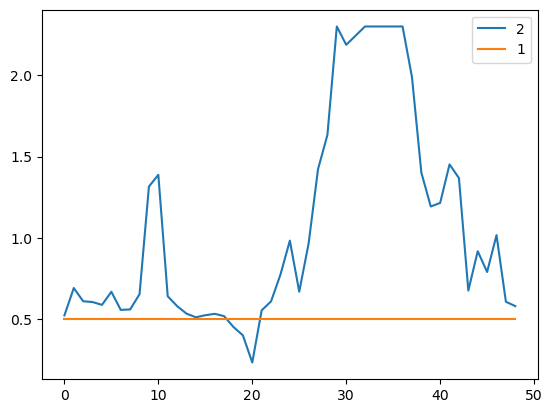

In [868]:
pp = np.array(var_values(p_g))
pp = pp.reshape(49,2)
plt.plot(pp)
plt.legend({'1','2'})

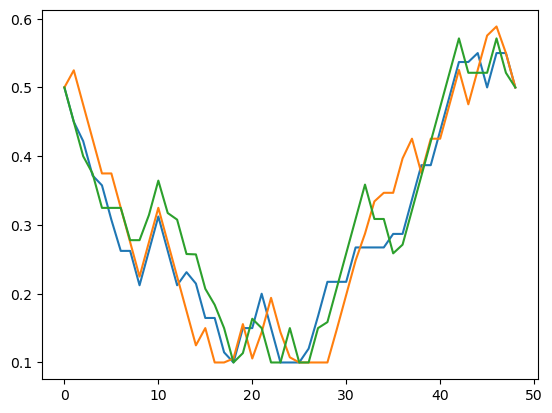

In [869]:
asd = np.array(var_values(soc_e))
asd = asd.reshape(49,3)
plt.plot(asd)
# Pline = []
# for i in Pl_full:
#     Pline.append(round(i,2))
import scipy.io
# scipy.io.savemat('./matfigures/soc.mat',dict(soc=asd))

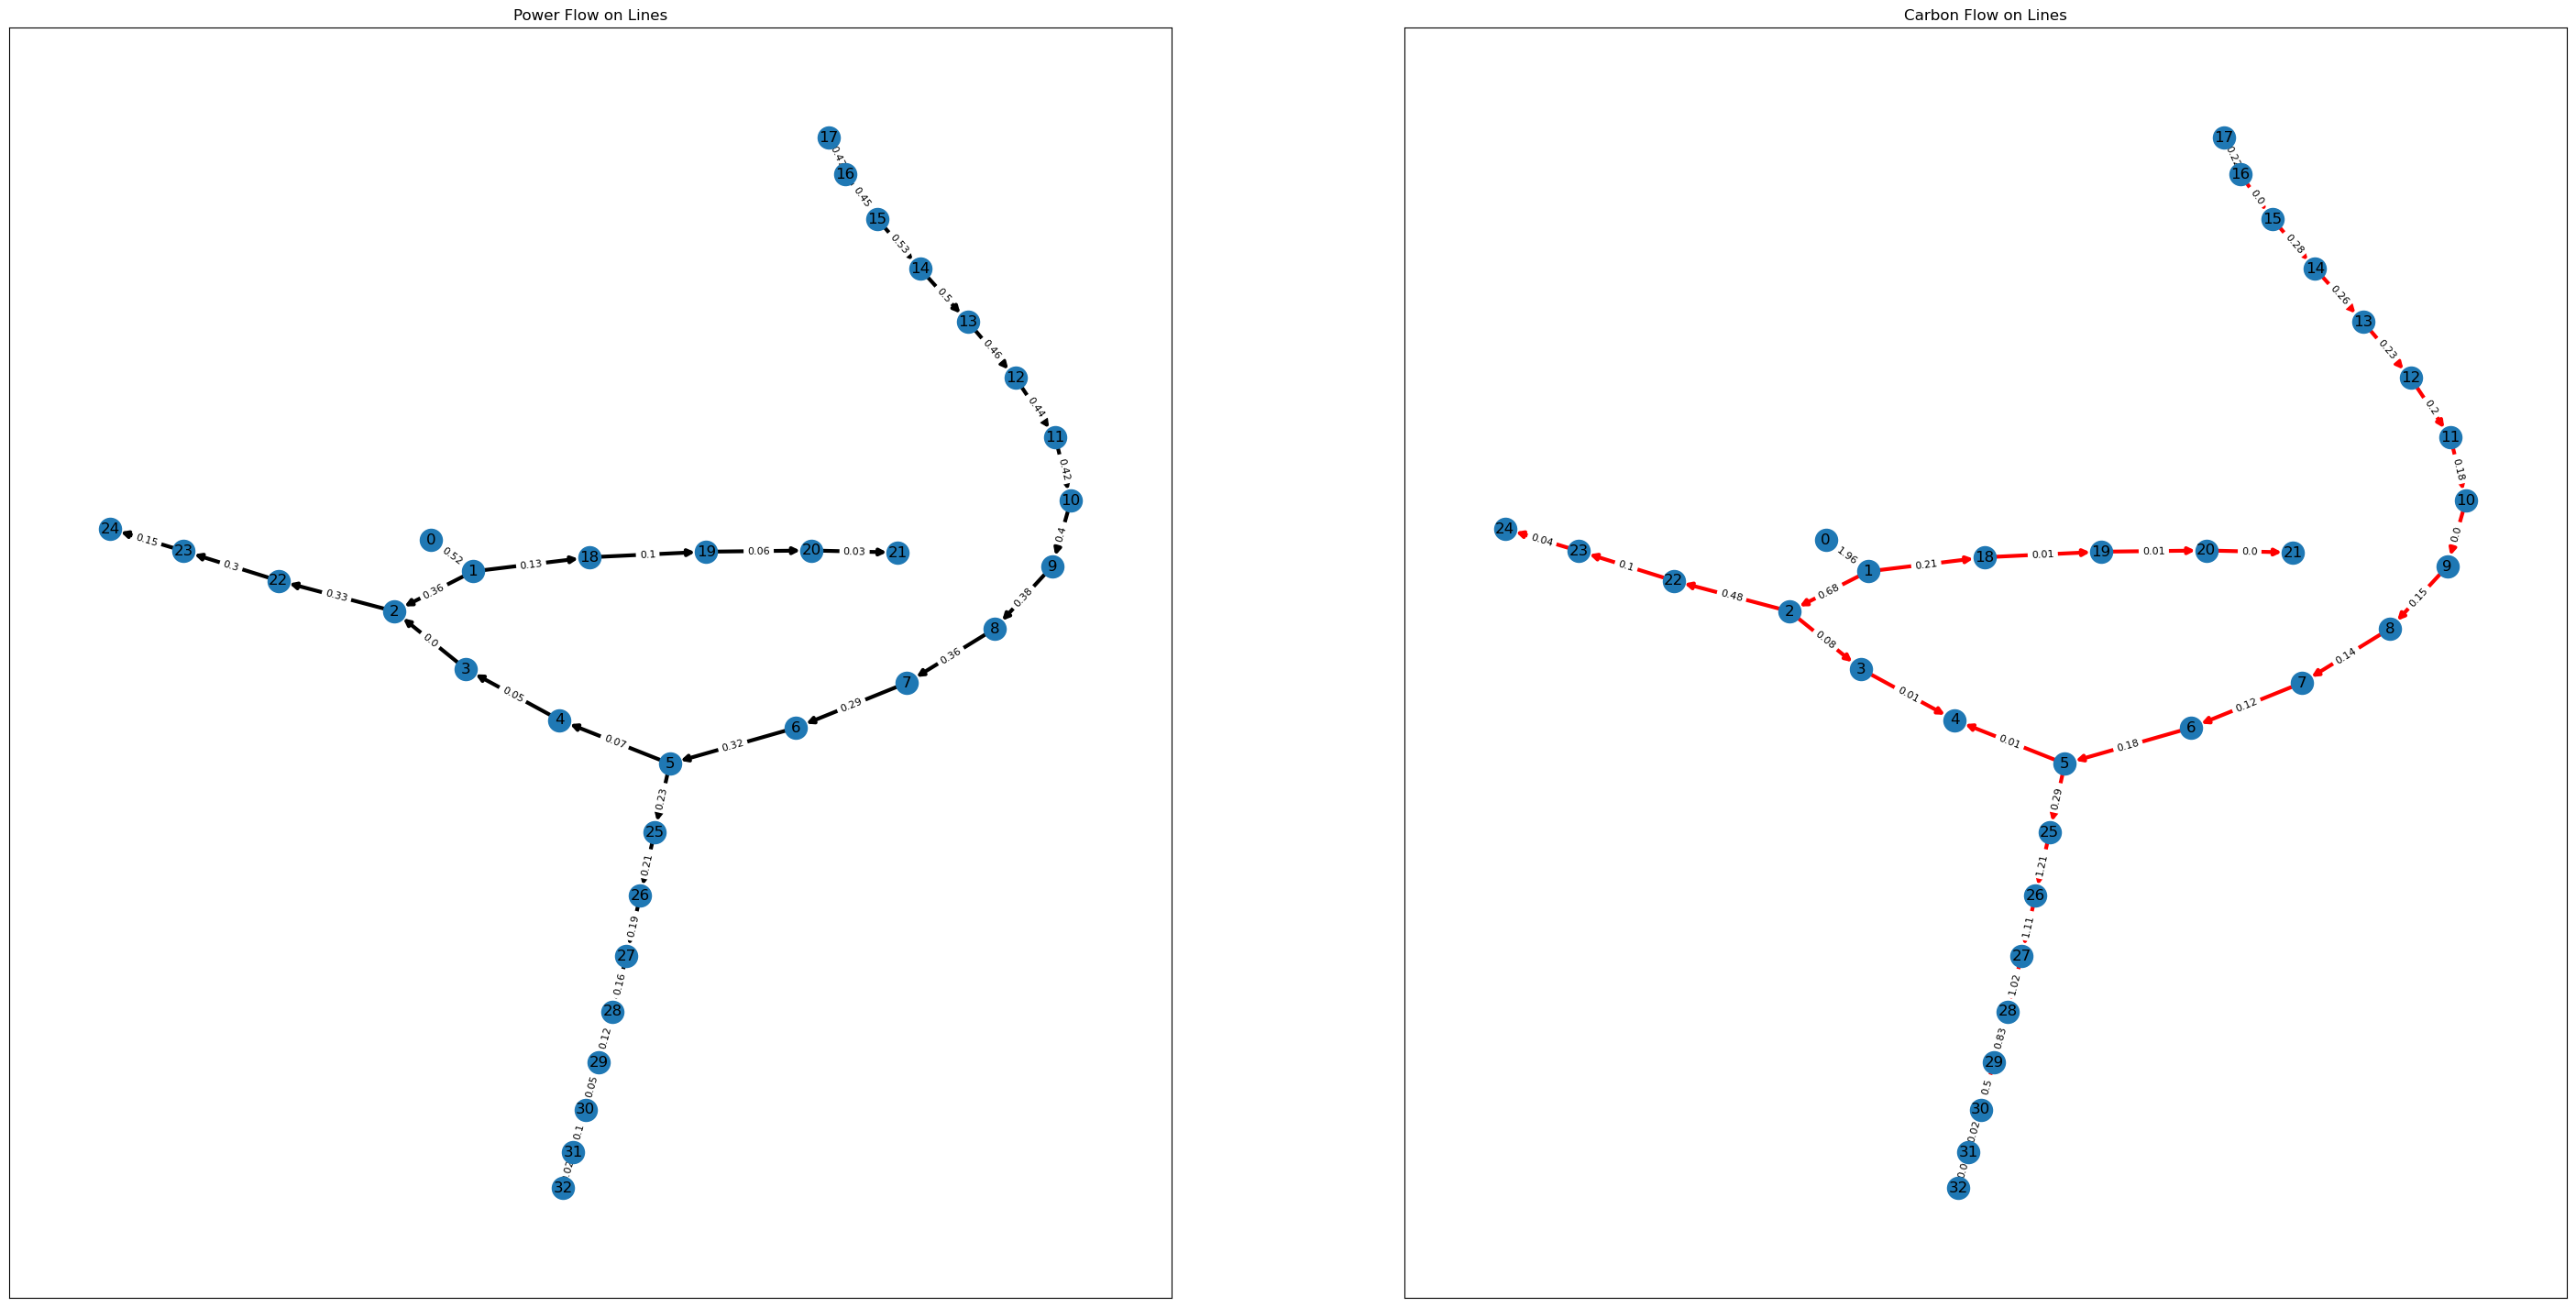

In [870]:
import networkx as nx

Pl_full = var_values(p_ij,MVAbase)
Pline = []
for i in Pl_full:
    Pline.append(round(i,2))
    
plt.figure(figsize=[36,18])
# plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
plt.title('Power Flow on Lines')

# Dummy positioning
F = nx.Graph()
F.add_edges_from(line.index)
pos = nx.spring_layout(F, iterations=100, seed=420)
# pos = nx.multipartite_layout(F)

# Directed flows
G = nx.DiGraph()
gd = net.bus_geodata
k = 0
# for i in bus.index:
    # G.add_node(i,pos=(gd.x[i],gd.y[i]))
    # pos[i] = np.array([gd.x[i],gd.y[i]])

for i in line.index:
    # print(i)
    if Pline[k] > 0:
        G.add_edge(i[0],i[1],weight=abs(Pline[k]))
    else:
        G.add_edge(i[1],i[0],weight=abs(Pline[k]))
    k = k+1
# pos = nx.spring_layout(G, iterations=100, seed=4)
nx.draw_networkx(G,pos, with_labels=True, width=3, arrowstyle='-|>')
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)

plt.subplot(1,2,2)
plt.title('Carbon Flow on Lines')
# Calculate the Carbon Flow Rate at lines
p_idx = [i for i in line_t_dir if p_hat[i].X > 0]

H = nx.DiGraph()
for i,j,t in p_idx:
    if t==T-1:
        val = w_i[i,t].X*p_hat[i,j,t].X*MVAbase
        H.add_edge(i,j,weight=round(val,2))

p = nx.draw_networkx(H,pos, with_labels=True, width=3, arrowstyle='-|>', edge_color='red')
edge_labels = nx.get_edge_attributes(H, "weight")
q = nx.draw_networkx_edge_labels(H, pos, edge_labels, font_size=8)

In [871]:
w_i.select('*',T-1)

[<gurobi.Var node_int[0,48] (value 3.3762559246403296)>,
 <gurobi.Var node_int[1,48] (value 1.6237440753596701)>,
 <gurobi.Var node_int[2,48] (value 1.4598349839288651)>,
 <gurobi.Var node_int[3,48] (value 1.0964843898866459)>,
 <gurobi.Var node_int[4,48] (value 1.053725496469914)>,
 <gurobi.Var node_int[5,48] (value 1.0323460497615482)>,
 <gurobi.Var node_int[6,48] (value 0.5831484201915575)>,
 <gurobi.Var node_int[7,48] (value 0.4118835978303377)>,
 <gurobi.Var node_int[8,48] (value 0.3809606712392517)>,
 <gurobi.Var node_int[9,48] (value 0.4023401179476167)>,
 <gurobi.Var node_int[10,48] (value 0.0)>,
 <gurobi.Var node_int[11,48] (value 0.439754149687257)>,
 <gurobi.Var node_int[12,48] (value 0.4611335963956229)>,
 <gurobi.Var node_int[13,48] (value 0.5038924898123547)>,
 <gurobi.Var node_int[14,48] (value 0.5252719365207206)>,
 <gurobi.Var node_int[15,48] (value 0.5252719365207206)>,
 <gurobi.Var node_int[16,48] (value 0.0)>,
 <gurobi.Var node_int[17,48] (value 0.46803082993745093)

In [872]:
soh_e

{(6, 0): <gurobi.Var SOH[6,0] (value 1.0)>,
 (15, 0): <gurobi.Var SOH[15,0] (value 1.0)>,
 (30, 0): <gurobi.Var SOH[30,0] (value 1.0)>,
 (6, 1): <gurobi.Var SOH[6,1] (value 0.99994)>,
 (15, 1): <gurobi.Var SOH[15,1] (value 0.9999700998553563)>,
 (30, 1): <gurobi.Var SOH[30,1] (value 0.99994)>,
 (6, 2): <gurobi.Var SOH[6,2] (value 0.9999063172784699)>,
 (15, 2): <gurobi.Var SOH[15,2] (value 0.9999100998553564)>,
 (30, 2): <gurobi.Var SOH[30,2] (value 0.9998800000000001)>,
 (6, 3): <gurobi.Var SOH[6,3] (value 0.99984631727847)>,
 (15, 3): <gurobi.Var SOH[15,3] (value 0.9998500998553564)>,
 (30, 3): <gurobi.Var SOH[30,3] (value 0.999849804357367)>,
 (6, 4): <gurobi.Var SOH[6,4] (value 0.9998291002230784)>,
 (15, 4): <gurobi.Var SOH[15,4] (value 0.9997900998553564)>,
 (30, 4): <gurobi.Var SOH[30,4] (value 0.9997898043573671)>,
 (6, 5): <gurobi.Var SOH[6,5] (value 0.9997691002230784)>,
 (15, 5): <gurobi.Var SOH[15,5] (value 0.9997900998553564)>,
 (30, 5): <gurobi.Var SOH[30,5] (value 0.9997